# Phase 6: Proactive Pattern Detection
>_(Part of the Data Science lifecycle for uncovering high-risk clusters & anomalies)_

#### **Objective:**
Use **unsupervised learning** techniques to surface _hidden structure_, such as:
* **Alias clusters** (e.g. same entity across alt names)
* **Outlier behavior** (e.g. odd country associations)
* **Potential identity masking** strategies
#### **Signifance:**
- Extend the model's reach from point-wise prediction to group-wise and behavioral detection - this is what powers **early warning systems** and **entity resolution pipelines** in financial compliance systems.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

#### **Load & Prepare Features:**

In [3]:
df = pd.read_csv("../data/sanctions_features.csv")
df = df[df["fuzz_ratio_reference"].notna()].copy()

df["is_match"] = ((df["fuzz_ratio"] > 65) & (df["common_token_count"] > 0)).astype(int)

matched_df = df[df["is_match"] == 1].copy()

print(matched_df["is_match"].value_counts())

is_match
1    3986
Name: count, dtype: int64


#### **Clustering for Alias Networks (DBSCAN):**

Normalize Features

In [4]:
features = [
    "fuzz_ratio", 
    "token_sort_ratio", 
    "length_diff", 
    "common_token_count", 
    "prefix_match", 
    "word_count_1", 
    "word_count_2"
]
X = StandardScaler().fit_transform(matched_df[features])

Run DBSCAN

In [5]:
db = DBSCAN(eps=0.3, min_samples=3).fit(X)
matched_df["cluster"] = db.labels_

Visualize

c:\xampp\htdocs\data-engineering\ofac-end-to-end-data-project\sanction-risk-ml\venv\Lib\site-packages\sklearn\decomposition\_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


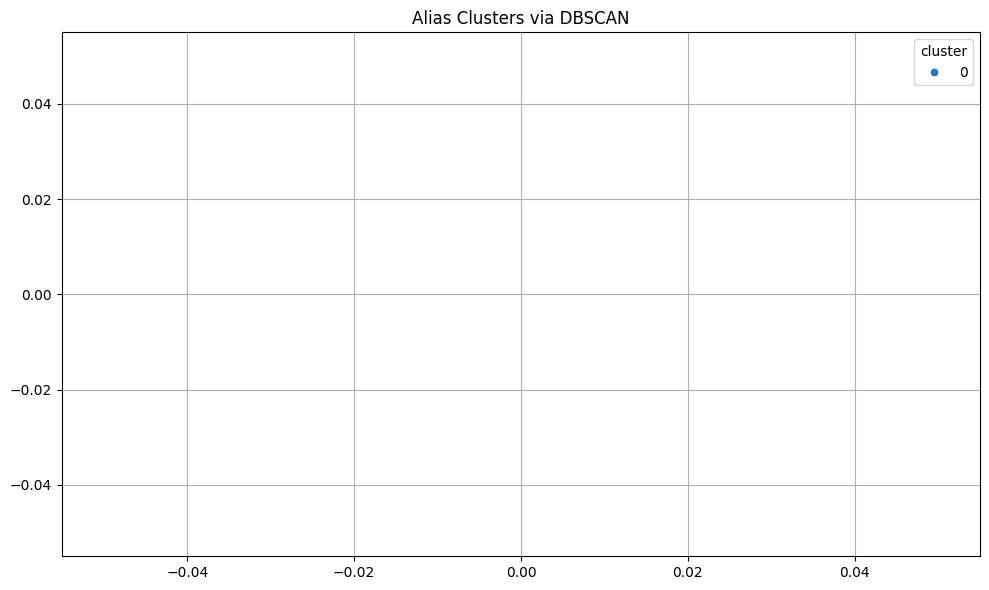

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], hue=matched_df["cluster"], palette="tab10")
plt.title("Alias Clusters via DBSCAN")
plt.tight_layout()
plt.grid(True)
plt.show()

#### **Outlier Detection (Isolation Forest):**

Train & Predict

In [7]:
anomaly_model = IsolationForest(contamination=0.01, random_state=42)
anomaly_scores = anomaly_model.fit_predict(X)

matched_df["anomaly"] = anomaly_scores


Export high-risk

In [8]:
anomalies = matched_df[matched_df["anomaly"] == -1]
anomalies[["fuzz_ratio", "token_sort_ratio", "length_diff", "common_token_count"]]

print(anomalies["anomaly"].value_counts())

Series([], Name: count, dtype: int64)


In [9]:
anomalies.to_csv("../data/high_risk_anomalies.csv", index=False)
matched_df.to_csv("../data/pattern_detection.csv", index=False)
